<a href="https://colab.research.google.com/github/logicalschema/data620/blob/main/Data_620_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sung Su Lee**

**Data 620 Project 1: Spring 2021**

[Github Link](https://github.com/logicalschema/data620/tree/main/Project%201)  

[YouTube Video](https://youtu.be/T5oRH9Hqj-w)

<img src=https://raw.githubusercontent.com/logicalschema/data620/main/Project%201/data/Congress_feature.jpg width="400">


# Introduction

For this project, I chose to examine the Twitter interactions between Senators in the 117th Congress by looking at how senators follow one another on Twitter. Does party influence the network of Twitter interactions? In addition, this project looks to calculate the degree and eigenvector centrality values of each senator in the Twitter realm. Personally, I approach this project with a view that Congress is extremely polarized with each party's members in silos.

# Sources  

I used the following sources for this project: 
- [United States Senate Web Site](https://www.senate.gov/general/contact_information/senators_cfm.xml)  
Provided up to date contact information for the 117th Congress
- [Triage Cancer Social Media Page](https://triagecancer.org/congressional-social-media)  
Provided Twitter, Facebook, and other social media information about senators. There was a typo with Senator Lindsey Graham's Twitter and Senator Alex Padilla's information was incorrect.  
- [Developer Twitter Site](https://developer.twitter.com/en)  
Provided documentation for the Twitter API.



# Initial Hurdles  

My initial hurdles was understanding Twitter, working with the Twitter API, and correcting some inaccurate data. Twitter places limitations on API requests so gathering information on senators took a large chunk of time. In addition, one web site had mislabeled Senator Alex Padilla of California with VP Kamala Harris' Twitter information in addition to having a typo on Senator Lindsey Graham's Twitter id. 

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tabulate import tabulate
from IPython.display import display, HTML
import statistics
import math
from scipy.stats import t

senator_info_url = 'https://raw.githubusercontent.com/logicalschema/data620/main/Project%201/data/Final_senators_social_media.csv'
twitter_relationships_url = 'https://raw.githubusercontent.com/logicalschema/data620/main/Project%201/data/Final_senator_twitter_relationships.csv'

# colnames = ['State', 'Status', 'Name', 'NameLink', 'Party', 'Twitter', 'TwitterLink', 'Instagram', 'InstagramLink', 'Facebook', 'FacebookLink']
data = pd.read_csv(senator_info_url, index_col=0)

# Remove the leading @ character
data['Twitter'] = data['Twitter'].str.strip()
data['Twitter'] = data['Twitter'].str.replace('@','')

# Construct a dictionary to lookup Twitterids. I will use the dataframe index for an index
twitterLookup = {}
twitterReverseLookup = {}

for index, row in data.iterrows():
    twitterLookup[str(row['Twitter'])] = index
    twitterReverseLookup[index] = str(row['Twitter'])

# Constructs the relationships which will be used for Graph edges
# Empty list of relationships
# Dataframe ('Twitter', 'Follower') means User: Twitter is followed by Follower
twitter_relationships = pd.read_csv(twitter_relationships_url, header=None)
twitter_relationships.columns = ['User', 'Follower']

---
# Data View

Here are snippets of the data that has been imported.

**Senator Data**: the `data` dataframe contains such information as the senator's state, name, web site, and other social media information. I went through several iterations to complete the data and format it. 

In [ ]:
print(tabulate(data.head()))

-  -----------  ------------  -------------------  ---------------------------------------  -  ---------------  ------------------------------------------------------------------------------------------  ----------------  ------------------------------------------------  -  --------------------------------------------
0  Wisconsin    U.S. Senator  Baldwin, Tammy       https://www.baldwin.senate.gov/          D  SenatorBaldwin   https://twitter.com/SenatorBaldwin?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor   @senatorbaldwin   https://www.instagram.com/senatorbaldwin/?hl=en   x  https://www.facebook.com/senatortammybaldwin
1  Wyoming      U.S. Senator  Barrasso, John       https://www.barrasso.senate.gov/public/  R  SenJohnBarrasso  https://twitter.com/SenJohnBarrasso?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor  @senjohnbarrasso  https://www.instagram.com/senjohnbarrasso/?hl=en  x  https://www.facebook.com/johnbarrasso
2  Colorado     U.S. Senator  Bennet, Michael  

**Twitter Relationships**: the `twitter_relationships` data frame contains the `User` and `Follower` columns which denote the individual's Twitter username. 

For example,

|User      | Follower |
|----------|----------|
|LindseyGrahamSC| MarshaBlackburn|

means that `MarshaBlackburn` follows `LindseyGrahamSC` on Twitter. 

These relationships will be used to construct the edges of the graph.



In [ ]:
print(tabulate(twitter_relationships.head()))

-  ---------------  ---------------
0  LindseyGrahamSC  SenJohnBarrasso
1  LindseyGrahamSC  MarshaBlackburn
2  MarshaBlackburn  LindseyGrahamSC
3  LindseyGrahamSC  SenBlumenthal
4  LindseyGrahamSC  RoyBlunt
-  ---------------  ---------------


---
# Constructing the Graph

The graph will be constructed using the senators as nodes and their Twitter relationships as edges. The information stored in each node will be `State`, `Name`, `Party`, and `Twitter`.

In addition, the senators are organized into different groups: Republicans, Democrats, and Independents. These are simply arrays with the integer index of the senator.

Nodes and edges are added.

In [ ]:
# Create a graph
G = nx.Graph()

# Construct the nodes with some attributes from the dataframe
for index, row in data.iterrows():
	G.add_node(index, 
		State = str(row['State']),
		Name = str(row['Name']),
		Party = str(row['Party']),
		Twitter = str(row['Twitter'])
		)

# Construct the edges using the relationships dataframe
for index, row in twitter_relationships.iterrows():
	User = twitterLookup[row['User']]
	Follower = twitterLookup[row['Follower']]
	G.add_edge(User,Follower)

# Sorting nodes into Republican, Democrat, and Independent. Only the index is stored.
republicans = data.index[data['Party'] == 'R'].tolist()
democrats = data.index[data['Party'] == 'D'].tolist()
independents = data.index[data['Party'] == 'I'].tolist()

print("Indices for Republicans" + str(republicans))
print("Indices for Democrats" + str(democrats))
print("Indices for Independents" + str(independents))

Indices for Republicans[1, 3, 5, 7, 8, 10, 12, 16, 17, 19, 20, 21, 22, 23, 24, 26, 28, 30, 31, 32, 34, 38, 39, 40, 41, 44, 47, 49, 51, 54, 55, 58, 59, 64, 66, 68, 69, 71, 72, 74, 77, 78, 80, 84, 86, 87, 88, 89, 95, 97]
Indices for Democrats[0, 2, 4, 6, 9, 11, 13, 14, 15, 18, 25, 27, 29, 33, 35, 36, 37, 42, 43, 46, 48, 50, 52, 53, 56, 57, 60, 61, 62, 63, 65, 67, 70, 75, 76, 79, 81, 82, 83, 85, 90, 91, 92, 93, 94, 96, 98, 99]
Indices for Independents[45, 73]


# Nodes and Edges

To draw the graph, I decided to use different colors because of the number of nodes and edges in the graph. I represented the Republicans as red nodes, Democrats as blue nodes, and Independents as gray. The relationships are represented in the table below.

|Nature of Relationship|Color|
|------------|-------------|
|Intra-Republican Relationships| Orange |
|Intra-Democratic Relationships| Skyblue |
|Intra-Independent Relationships| Green|
|Inter-Party Relationships| Black|

## Nodes with Attributes
Here is a look at the attributes for the nodes.






In [ ]:
states = nx.get_node_attributes(G,'State')
names = nx.get_node_attributes(G,'Name')
parties = nx.get_node_attributes(G,'Party')
twitters = nx.get_node_attributes(G,'Twitter')

table = []
headers = ['State', 'Name', 'Party', 'Twitter']
for i in range(5):
  table.append([states[i], names[i], parties[i], twitters[i]])

display(HTML(tabulate(table, headers, tablefmt="html")))

State,Name,Party,Twitter
Wisconsin,"Baldwin, Tammy",D,SenatorBaldwin
Wyoming,"Barrasso, John",R,SenJohnBarrasso
Colorado,"Bennet, Michael",D,MichaelBennet
Tennessee,"Blackburn, Marsha",R,MarshaBlackburn
Connecticut,"Blumenthal, Richard",D,SenBlumenthal


# Drawing the Nodes
The following draws the nodes for the graph.

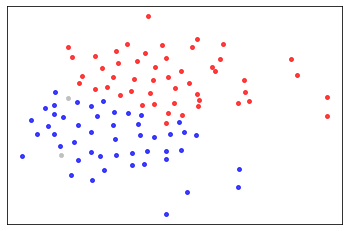

In [ ]:
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_size = 15, nodelist = republicans, node_color = 'red', alpha = 0.75)
nx.draw_networkx_nodes(G, pos, node_size = 15, nodelist = democrats, node_color = 'blue', alpha = 0.75)
nx.draw_networkx_nodes(G, pos, node_size = 15, nodelist = independents, node_color = 'silver')


# Drawing the Edges
The following code draws the edges between the nodes.  

An observation that surprised me was to see the number of inter-party relationships. Senators from opposite parties were following one another on Twitter. I had expected a dichotomy in relationships. I was glad to see that there were relationships between senators of opposite parties.

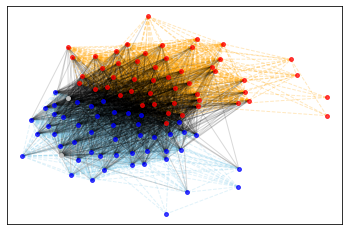

In [ ]:
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_size = 15, nodelist = republicans, node_color = 'red', alpha = 0.75)
nx.draw_networkx_nodes(G, pos, node_size = 15, nodelist = democrats, node_color = 'blue', alpha = 0.75)
nx.draw_networkx_nodes(G, pos, node_size = 15, nodelist = independents, node_color = 'silver')

edges = G.edges()
rep_relationships = []
dem_relationships = []
ind_relationships = []
out_relationships = []

# Determines which edges are between nodes that are not in the same party or same party
for edge in edges:
	if (edge[0] in republicans and edge[1] in republicans):
		rep_relationships.append(edge)
	elif (edge[0] in democrats and edge[1] in democrats):
		dem_relationships.append(edge)
	elif (edge[0] in independents and edge[1] in independents):
		ind_relationships.append(edge)
	else:
		out_relationships.append(edge)

nx.draw_networkx_edges(
    G,
    pos,
    edgelist=rep_relationships,
    width = 1,
    style = "dashed",
    alpha = 0.25,
    edge_color="orange"
)

nx.draw_networkx_edges(
    G,
    pos,
    edgelist=dem_relationships,
    width = 1,
    style = "dashed",
    alpha = 0.25,
    edge_color="skyblue"
)

nx.draw_networkx_edges(
    G,
    pos,
    edgelist=ind_relationships,
    width = 1,
    style = "dashed",    
    alpha = 0.15,
    edge_color="green"
)

nx.draw_networkx_edges(
    G,
    pos,
    edgelist=out_relationships,
    width = 1,
    alpha = 0.15,
    edge_color="black"
)

# Degree Centrality and Eigenvector Centrality

This section will calculate degree centrality and eigenvector centrality for each node.

## Degree Centrality

Degree centrality can be calculated using the `degree_centrality` function. More information can be found [here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html).


In [ ]:
# Calculates the degree centrality for each node
deg_centralities = nx.degree_centrality(G)

# Prints a sample of the centralities
table = []
headers = ['Node', 'Twitter', 'Degree Centrality']
for i in range(5):
  table.append([i, twitterReverseLookup[i], deg_centralities[i]])

for i in range(len(deg_centralities) - 5, len(deg_centralities)):
  table.append([i, twitterReverseLookup[i], deg_centralities[i]])

display(HTML(tabulate(table, headers, tablefmt="html")))

Node,Twitter,Degree Centrality
0,SenatorBaldwin,0.828283
1,SenJohnBarrasso,0.737374
2,MichaelBennet,0.111111
3,MarshaBlackburn,0.555556
4,SenBlumenthal,0.666667
95,SenatorWicker,0.69697
96,RonWyden,0.757576
97,SenToddYoung,0.464646
98,SenCortezMasto,0.787879
99,SenDuckworth,0.727273


## Eigenvector Centrality

The eigenvector centrality can be calculated using the function `eigenvector_centrality`. Additional information can be found [here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality.html).

In [ ]:
# Calculates the eigenvector centrality for each node
eig_centralities = nx.eigenvector_centrality(G)

# Prints a sample of the centralities
table = []
headers = ['Node', 'Twitter', 'Eigenvector Centrality']
for i in range(5):
  table.append([i, twitterReverseLookup[i], eig_centralities[i]])

for i in range(len(eig_centralities) - 5, len(eig_centralities)):
  table.append([i, twitterReverseLookup[i], eig_centralities[i]])

display(HTML(tabulate(table, headers, tablefmt="html")))

Node,Twitter,Eigenvector Centrality
0,SenatorBaldwin,0.122513
1,SenJohnBarrasso,0.10812
2,MichaelBennet,0.014081
3,MarshaBlackburn,0.0764617
4,SenBlumenthal,0.100687
95,SenatorWicker,0.103686
96,RonWyden,0.113987
97,SenToddYoung,0.0683995
98,SenCortezMasto,0.11741
99,SenDuckworth,0.109879


# Comparison of Centrality Measures

Here are the top ten for each of the centrality measures.

In [ ]:
sorted_deg_centralities = dict(sorted(deg_centralities.items(), key=lambda item: item[1], reverse=True))
sorted_eig_centralities = dict(sorted(eig_centralities.items(), key=lambda item: item[1], reverse=True))

dict_deg = sorted_deg_centralities.items()
dict_eig = sorted_eig_centralities.items()
table1 = []
table2 = []

headers1 = ['Name', 'Party', 'Degree Centralities']
headers2 = ['Name', 'Party', 'Eigenvector Centralities']

temp1 = list(dict_deg)[:10]
temp2 = list(dict_eig)[:10]

for item in temp1:
  table1.append([names[item[0]], parties[item[0]], item[1]])

for item in temp2:
  table2.append([names[item[0]], parties[item[0]], item[1]])


**Top 10 Degree Centralities**

According to the `Networkx` documentation, the degree centrality score is calculated for a node by examining the fraction of nodes it is connected to. Surprisingly, the majority of the top ten nodes for degree centralities are Republicans $\frac{4}{5}$ compared to Democrats for $\frac{2}{5}$




In [ ]:

display(HTML(tabulate(table1, headers1, tablefmt="html")))


Name,Party,Degree Centralities
"Marshall, Roger",R,0.939394
"Johnson, Ron",R,0.929293
"Cantwell, Maria",D,0.89899
"Murkowski, Lisa",R,0.888889
"Scott, Tim",R,0.888889
"Lankford, James",R,0.868687
"Collins, Susan",R,0.858586
"Cornyn, John",R,0.858586
"Fischer, Deb",R,0.858586
"Manchin, Joe",D,0.858586


**Top 10 Eigenvector Centralities**

For top 10 eigenvalue centralities, Johnson-R is 1st instead of Marshall-R. In addition, Sinema-D, and Markey-D are in the list. According to *Social Network Analysis for Startups*, p 56, "An actor who is high on eigenvector centrality is connected to many actors who are themselves connected to many actors." A high eigenvector centrality score here means that the node is connected to other nodes that have high scores.

In [ ]:
display(HTML(tabulate(table2, headers2, tablefmt="html")))

Name,Party,Eigenvector Centralities
"Johnson, Ron",R,0.1302
"Marshall, Roger",R,0.129783
"Cantwell, Maria",D,0.128684
"Murkowski, Lisa",R,0.128167
"Scott, Tim",R,0.126651
"Sinema, Kyrsten",D,0.125601
"Markey, Edward",D,0.125222
"Collins, Susan",R,0.124943
"Fischer, Deb",R,0.124915
"Lankford, James",R,0.124906


---

# T-tests

Now, I wanted to perform a t-test for the difference of means between the Republican and Democratic parties in the Degree Centrality and Eigenvector Centrality Scores. I chose these two mainly because they are the rival majorities in the U.S. Senate. 

To start, I will find the mean and standard deviation for the different groups for each centrality score.

## Degree Centrality t-test

First, I will work with the scores for both parties from the Degree Centrality Scores.


In [ ]:
# Obtain the Republican and Democrat indices
reps = []
dems = []
for key in parties.keys():
  if parties[key] == 'R':
    reps.append(key)
  elif parties[key] == 'D':
    dems.append(key)

# Obtain the scores for each party
rep_scores = []
dem_scores = []

for key in reps:
  rep_scores.append(deg_centralities[key])

for key in dems:
  dem_scores.append(deg_centralities[key])


# Obtain the means and standard deviations of each party
table = []
headers = [' ', 'Republicans', 'Democrats']
r_mean = statistics.mean(rep_scores)
r_std = statistics.stdev(rep_scores)
r_num = len(rep_scores)

d_mean = statistics.mean(dem_scores)
d_std = statistics.stdev(dem_scores)
d_num = len(dem_scores)

table.append(["Mean", r_mean, d_mean])
table.append(["Standard Deviation", r_std, d_std])
table.append(["Number of Scores", r_num, d_num])

display(HTML(tabulate(table, headers, tablefmt="html")))


,Republicans,Democrats
Mean,0.634141,0.658249
Standard Deviation,0.234134,0.196699
Number of Scores,50,48


I will make the null hypothesis that the scores are the same and the alternate hypothesis is that the scores are not the same:  

$H_0: \mu_R = \mu_D$  
$H_A: \mu_R \ne \mu_D$  

I will use a significance level $\alpha = 0.05$

The t statistic is calculated by using the formula:

$$t = \frac{\bar{X}_R - \bar{X}_D}{\sqrt{ \frac{s_R^2}{n_R} + \frac{s^2_D}{n_D}   }}$$  



In [ ]:
r_mean = statistics.mean(rep_scores)
r_std = statistics.stdev(rep_scores)
r_num = len(rep_scores)


t_value = (r_mean - d_mean) / math.sqrt( ( r_std**2 / r_num  ) + (d_std**2 / d_num))

# I used degrees of freedom = 47 (1 less than the smallest sample size)
p_value = t.sf(abs(t_value), d_num - 1) * 2

print("The t-value is " + str(t_value))
print("The p-value is " + str(p_value))

The t-value is -0.5527170667514161
The p-value is 0.5830765192355435


$$P(|t| \ge 0.5527) \approx 0.5831$$  

The p-value is greater than our significance level of 0.05. There is not sufficient evidence to reject the null hypothesis. There is not a difference in the scores between the parties for degree centrality.

---

## Eigenvector Centrality t-test

Next, I will work with the scores for both parties from the Eigenvector Centrality Scores.

In [ ]:
# Obtain the scores for each party
rep_scores = []
dem_scores = []

for key in reps:
  rep_scores.append(eig_centralities[key])

for key in dems:
  dem_scores.append(eig_centralities[key])


# Obtain the means and standard deviations of each party
table = []
headers = [' ', 'Republicans', 'Democrats']
r_mean = statistics.mean(rep_scores)
r_std = statistics.stdev(rep_scores)
r_num = len(rep_scores)

d_mean = statistics.mean(dem_scores)
d_std = statistics.stdev(dem_scores)
d_num = len(dem_scores)

table.append(["Mean", r_mean, d_mean])
table.append(["Standard Deviation", r_std, d_std])
table.append(["Number of Scores", r_num, d_num])

display(HTML(tabulate(table, headers, tablefmt="html")))

,Republicans,Democrats
Mean,0.0919557,0.0976238
Standard Deviation,0.0341269,0.0289991
Number of Scores,50,48



Similar to how we tested for the Degree Centrality Scores, we calculate for the Eigenvector Centrality Scores.



In [ ]:
r_mean = statistics.mean(rep_scores)
r_std = statistics.stdev(rep_scores)
r_num = len(rep_scores)


t_value = (r_mean - d_mean) / math.sqrt( ( r_std**2 / r_num  ) + (d_std**2 / d_num))

# I used degrees of freedom = 47 (1 less than the smallest sample size)
p_value = t.sf(abs(t_value), d_num - 1) * 2

print("The t-value is " + str(t_value))
print("The p-value is " + str(p_value))

The t-value is -0.8872407905042479
The p-value is 0.3794670820724275


$$P(|t| \ge 0.8872) \approx 0.3795$$  

The p-value is greater than our significance level of 0.05. There is not sufficient evidence to reject the null hypothesis. There is not a difference in the scores between the parties for eigenvector centrality scores.


---  

# Conclusion  

There does not seem to be evidence to support differences in party for degree or eigenvector centrality scores. Initially, I thought that Democrats would have an advantage in clout for influencing the network because of broad appeal. I stand corrected. 

In future studies, I hope to examine the relationships between party candidates and possibly how to improve relationships for a healthier government. Also, I appreciate the time spent in understanding the Twitter API and learning the intricacies of Twitter.